In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style('whitegrid')
sns.set_palette("husl")
import pandas as pd
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import itertools

In [2]:
def smooth_filter(comp_vals,ref_times):
    smoothed_vals = np.zeros((len(ref_times)))
    last_given_val = np.nan
    for sample,t in enumerate(ref_times):
        try:
            tid = max(np.where(comp_vals[:,0]<=t)[0])
            smoothed_vals[sample] = comp_vals[tid,1].copy()
            last_given_val = smoothed_vals[sample]
        except:
            smoothed_vals[sample] = last_given_val
    return smoothed_vals

def resample(comp_vals,nreps):
    individual_times,individual_values = np.diff(np.concatenate((np.zeros(1),comp_vals[:,0]))),comp_vals[:,1]
    buf = []
    apparition = np.arange(len(individual_times))
    for _ in range(nreps):
        t_cum,val_ = 0,np.inf
        simulation = []
        for t,val_cand in zip(individual_times[apparition],individual_values[apparition]):
            if val_cand<val_:
                val_ = val_cand
            t_cum += t
            simulation.append([t_cum,val_])
        buf.append(np.array(simulation))
        np.random.shuffle(apparition)
    return buf

<b>nominal/big n part</b>

In [3]:
names = ['nominal_experiment2','nominal_experiment','nominal_experiment2',\
        'nominal_experiment','bign_experiment2','bign_experiment','nominal_experiment3_part1','nominal_experiment3',\
        'bign_experiment3','nominal_experiment3_part2']
d_dims = [300,300,100,100,100,100,300,100,100,300]
r_vals = [100,100,10,10,10,10,100,10,10,100]
mult_vals = [1,1,10,10,1,1,1,10,1,1]
n_vals = [5e2,5e2,5e2,5e2,1e3,1e3,5e2,5e2,1e3,5e2]
m_vals = [1e4,1e4,1e4,1e4,1e3,1e3,1e4,1e4,1e3,1e4]
full_raw_df = None
for name,d,r,mult,n,m in zip(names,d_dims,r_vals,mult_vals,n_vals,m_vals):
    complete_name = name+'_'+str(d)+'_'+str(r)+'_'+str(mult)
    new_df = pd.read_csv(complete_name+'.csv')
    ln = len(new_df.values)
    new_df['d'] = d*np.ones(ln)
    new_df['r'] = r*np.ones(ln)
    new_df['mult'] = mult*np.ones(ln)
    new_df['n'] = n*np.ones(ln)
    new_df['m'] = m*np.ones(ln)
    if full_raw_df is None:
        full_raw_df = new_df
    else:
        full_raw_df = pd.concat([full_raw_df,new_df])
full_raw_df.drop(columns=['Unnamed: 0'],inplace=True)
full_raw_df.head(10)

,cut,omega,algo,times,bounds,bound_type,probID,repID,d,r,mult,n,m
0,5.0,0.0,ULO,3.500010,-1083.398523,UB,0,1,300.0,100.0,1.0,500.0,10000.0
1,5.0,0.0,ULO,3.500010,-inf,LB,0,1,300.0,100.0,1.0,500.0,10000.0
2,5.0,0.0,ULO,30.555083,-1083.398523,UB,0,1,300.0,100.0,1.0,500.0,10000.0
3,5.0,0.0,ULO,30.555083,-1207.031426,LB,0,1,300.0,100.0,1.0,500.0,10000.0
4,5.0,0.0,ULO,32.732086,-1125.256963,UB,0,1,300.0,100.0,1.0,500.0,10000.0
5,5.0,0.0,ULO,32.732086,-1207.031426,LB,0,1,300.0,100.0,1.0,500.0,10000.0
6,5.0,0.0,ULO,60.562135,-1125.256963,UB,0,1,300.0,100.0,1.0,500.0,10000.0
7,5.0,0.0,ULO,60.562135,-1159.236005,LB,0,1,300.0,100.0,1.0,500.0,10000.0
8,5.0,0.0,ULO,63.121140,-1125.256963,UB,0,1,300.0,100.0,1.0,500.0,10000.0
9,5.0,0.0,ULO,63.121140,-1159.236005,LB,0,1,300.0,100.0,1.0,500.0,10000.0


In [4]:
full_raw_df.shape

(300302, 13)

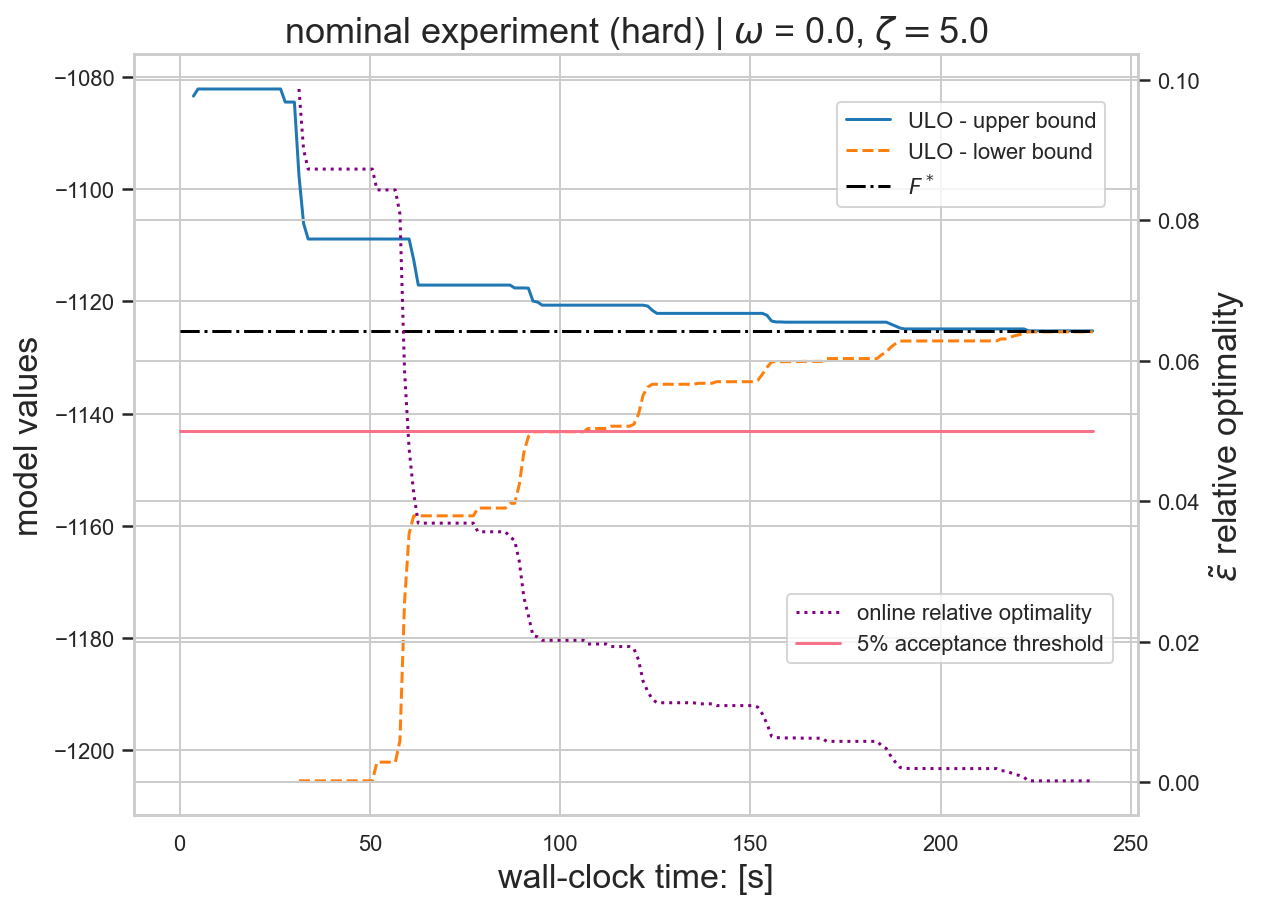

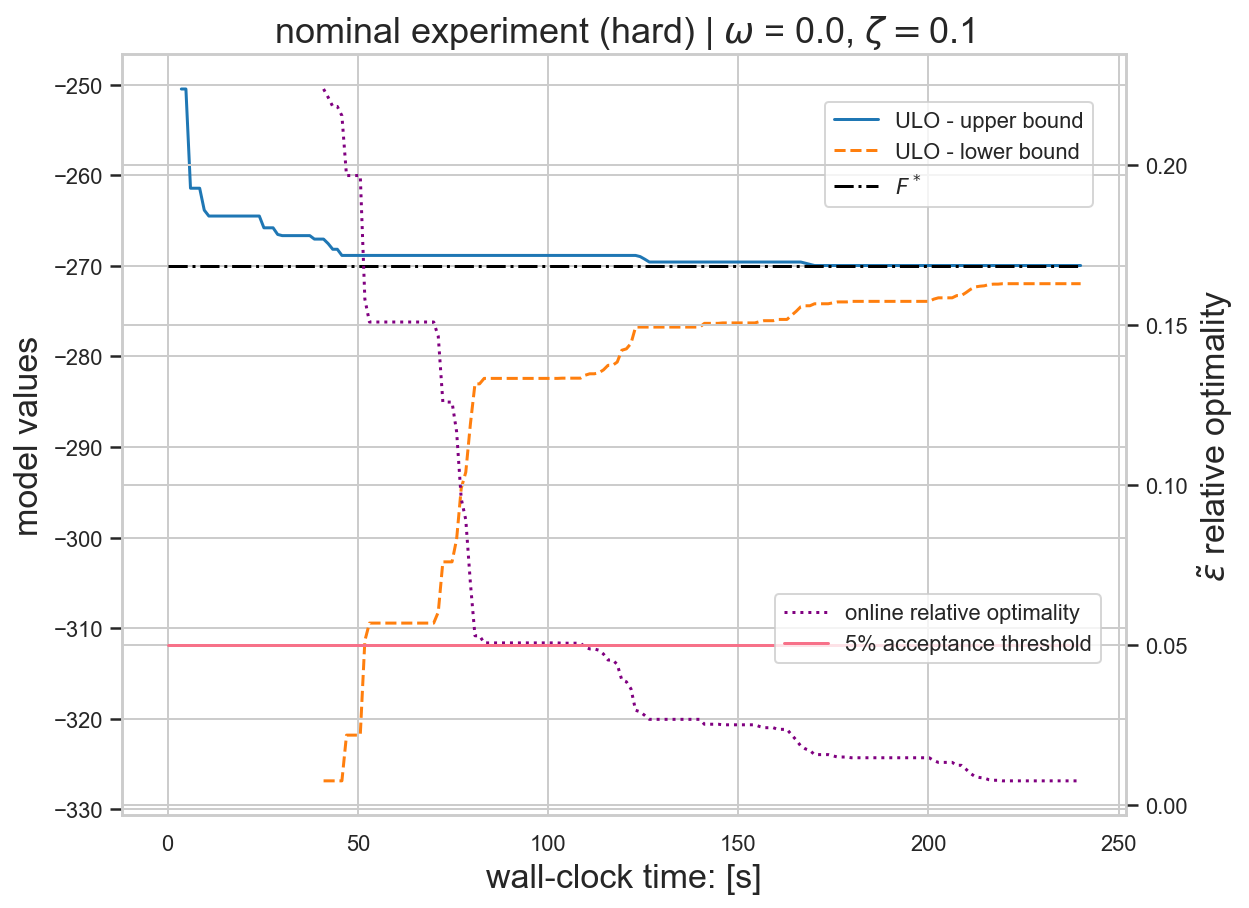

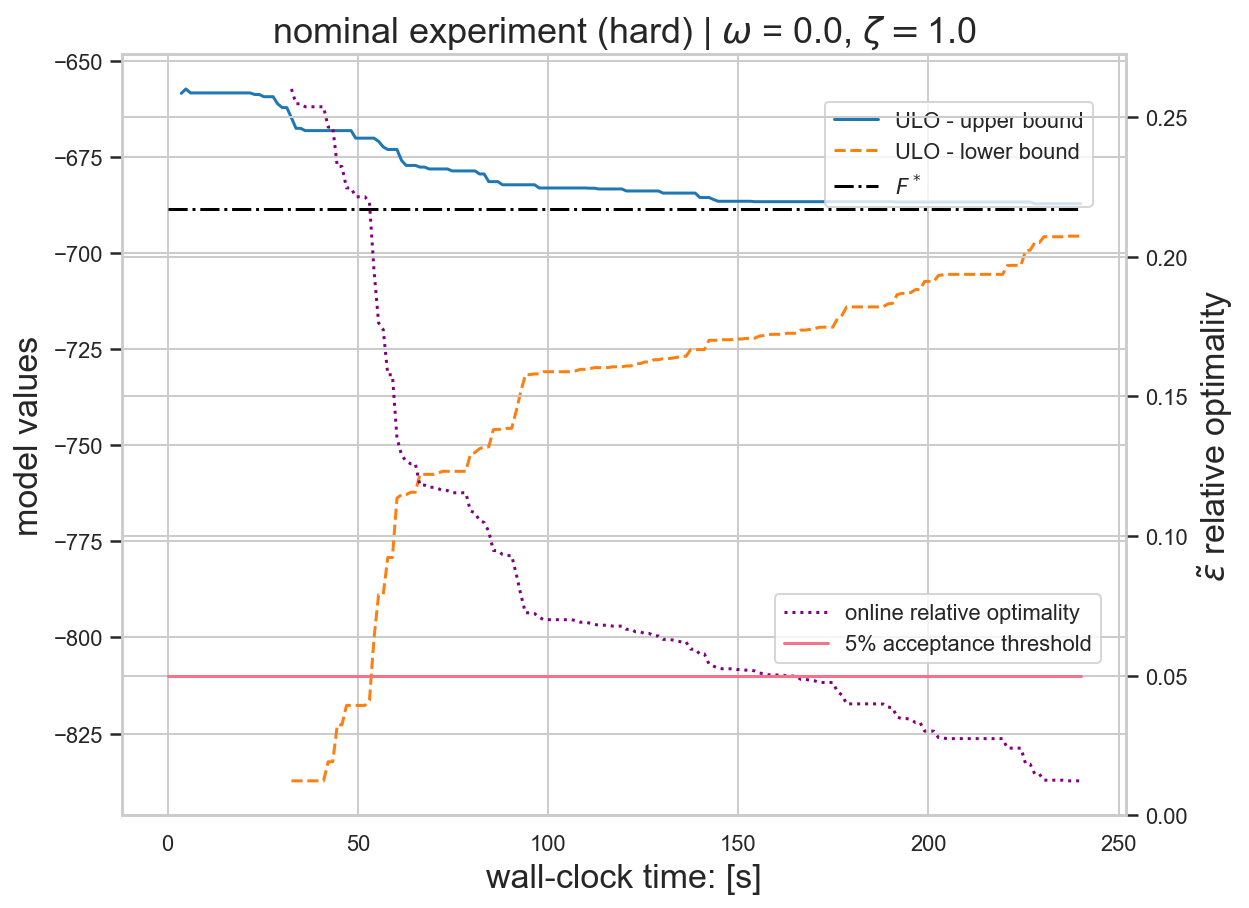

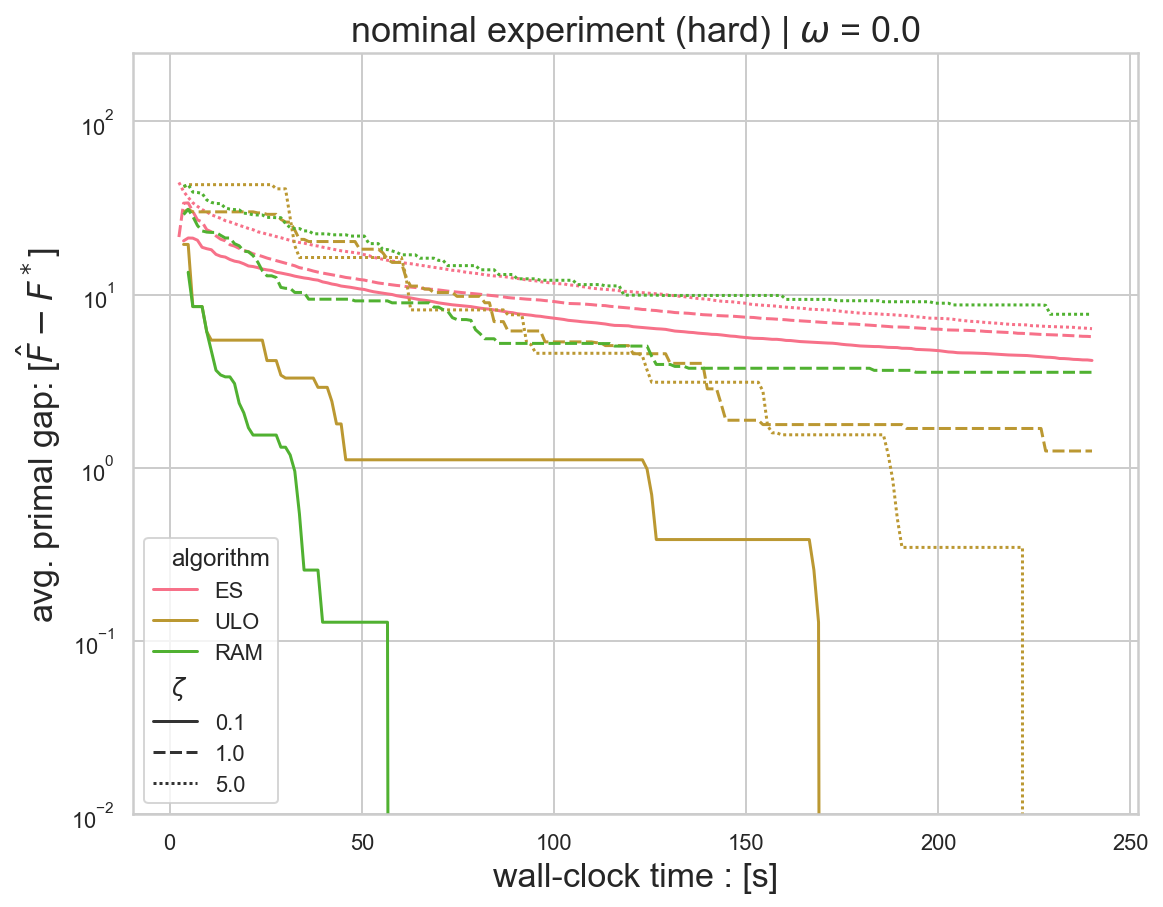

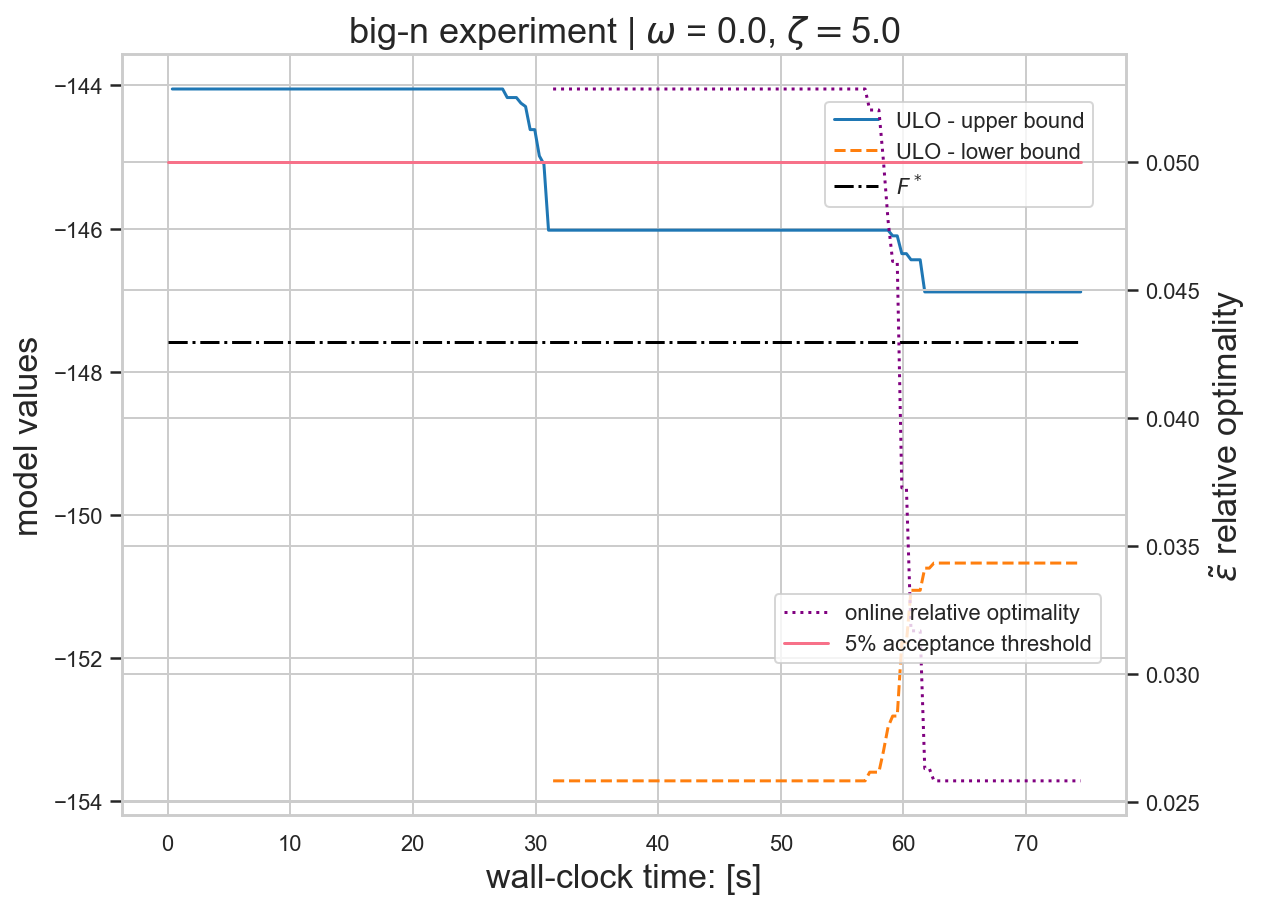

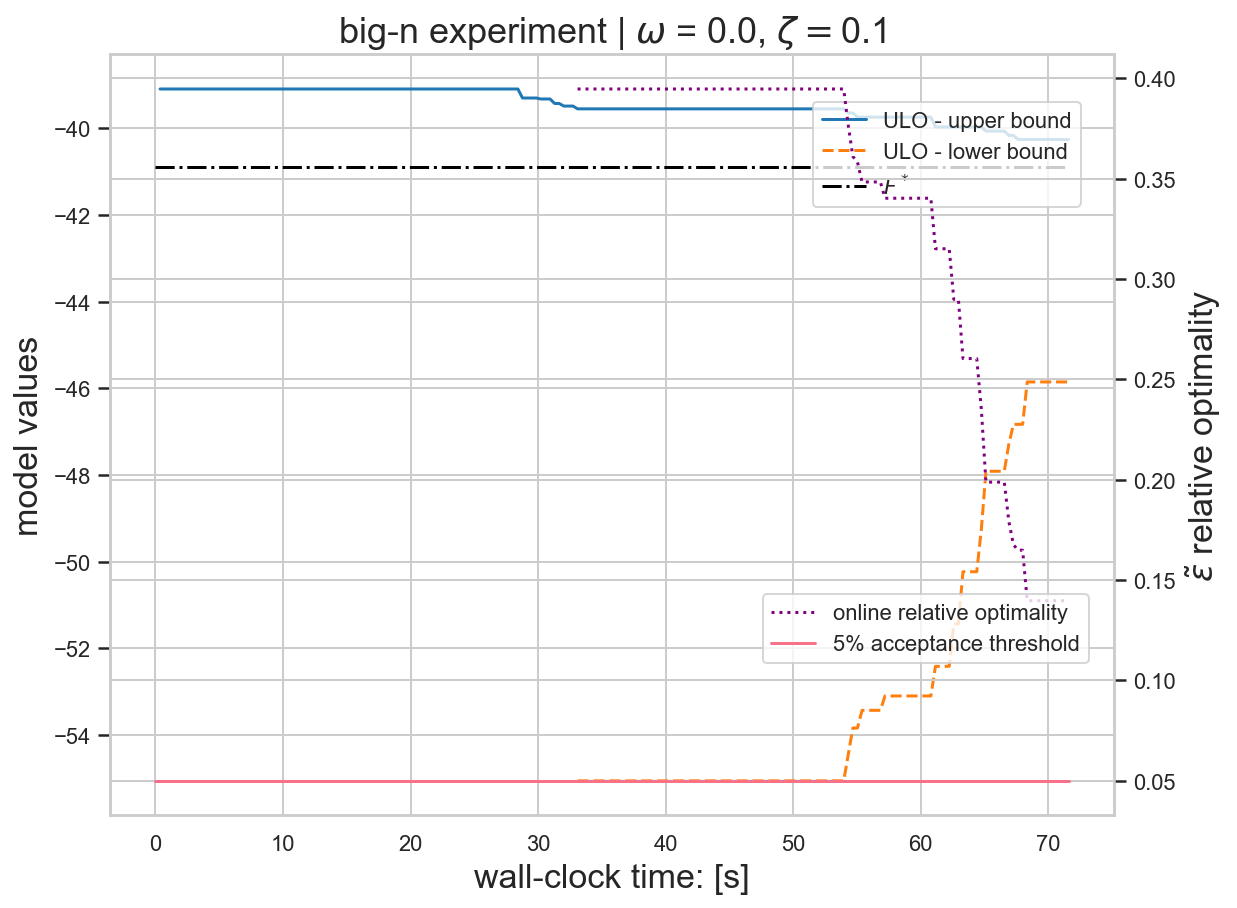

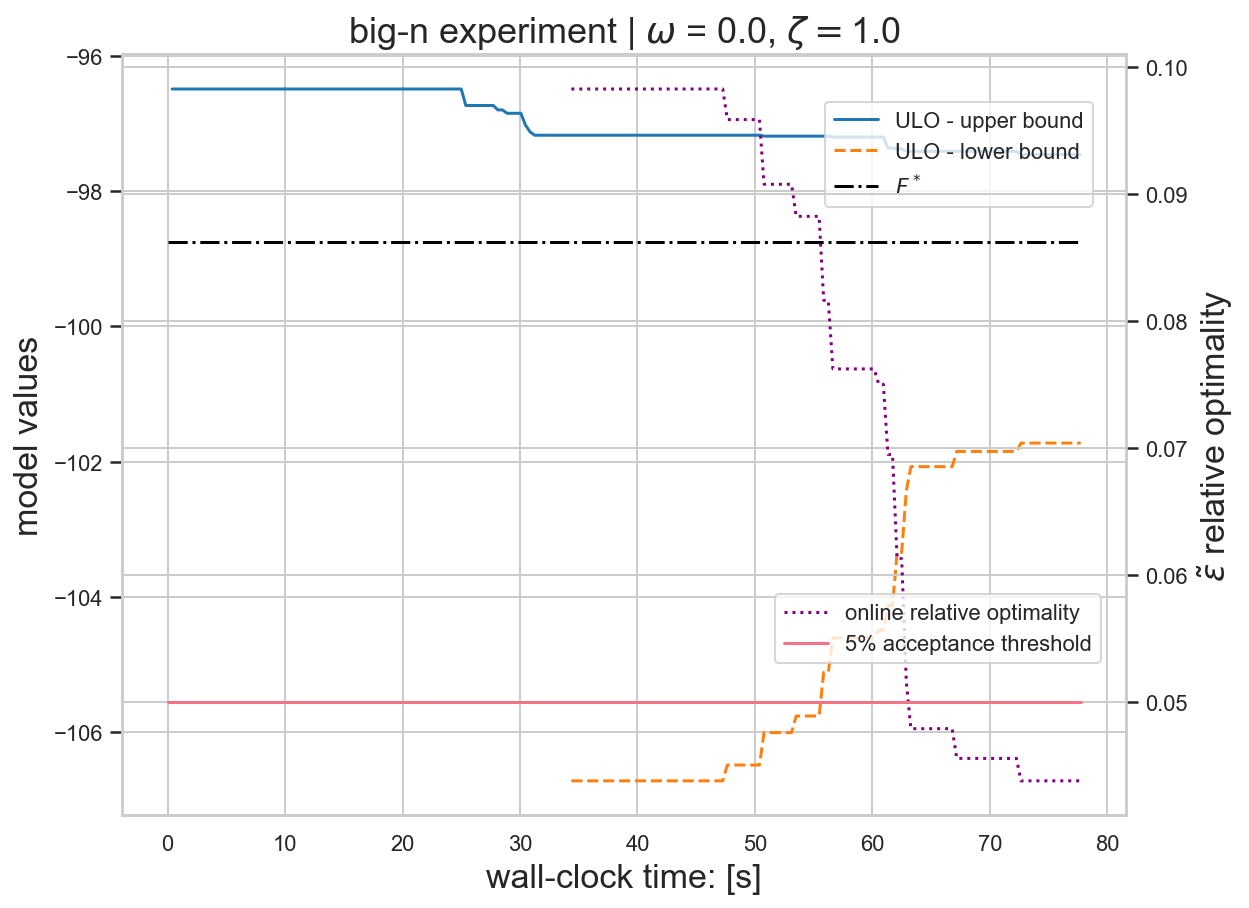

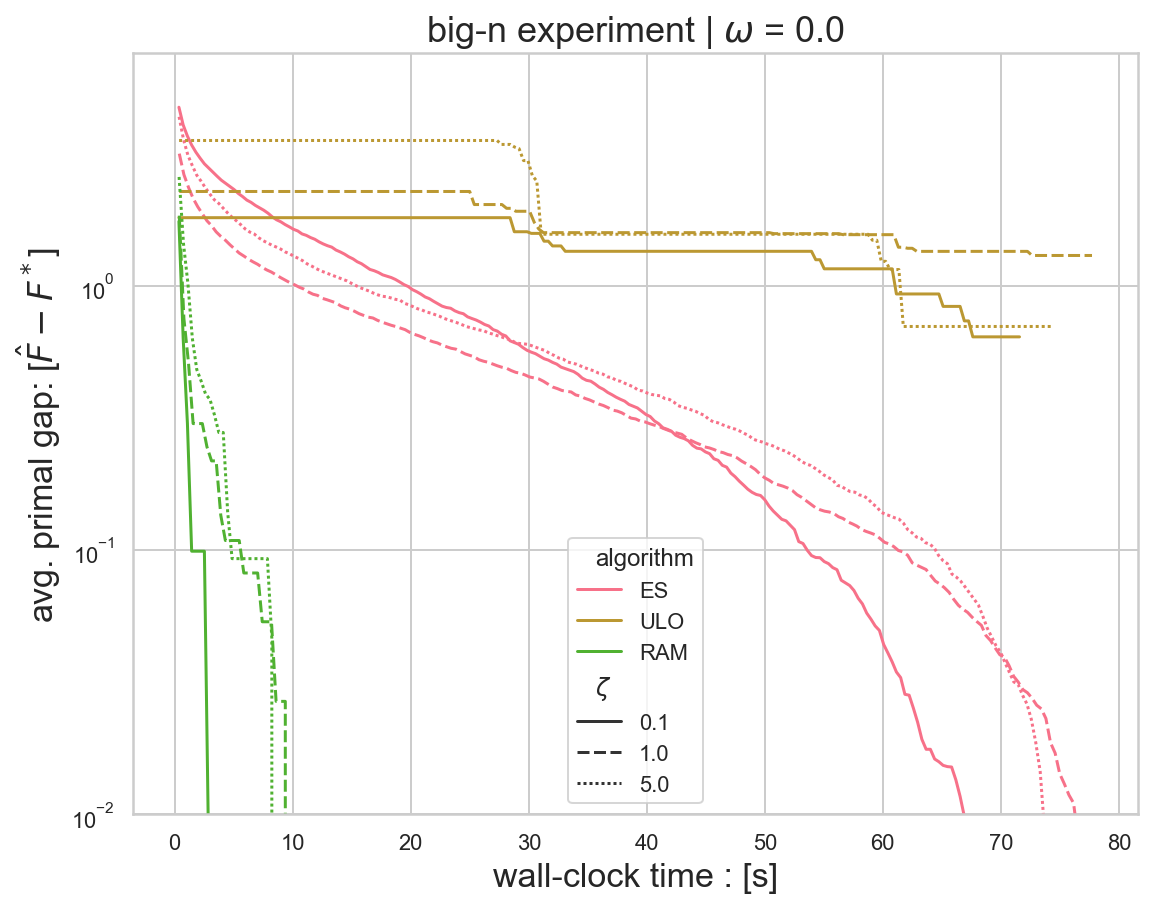

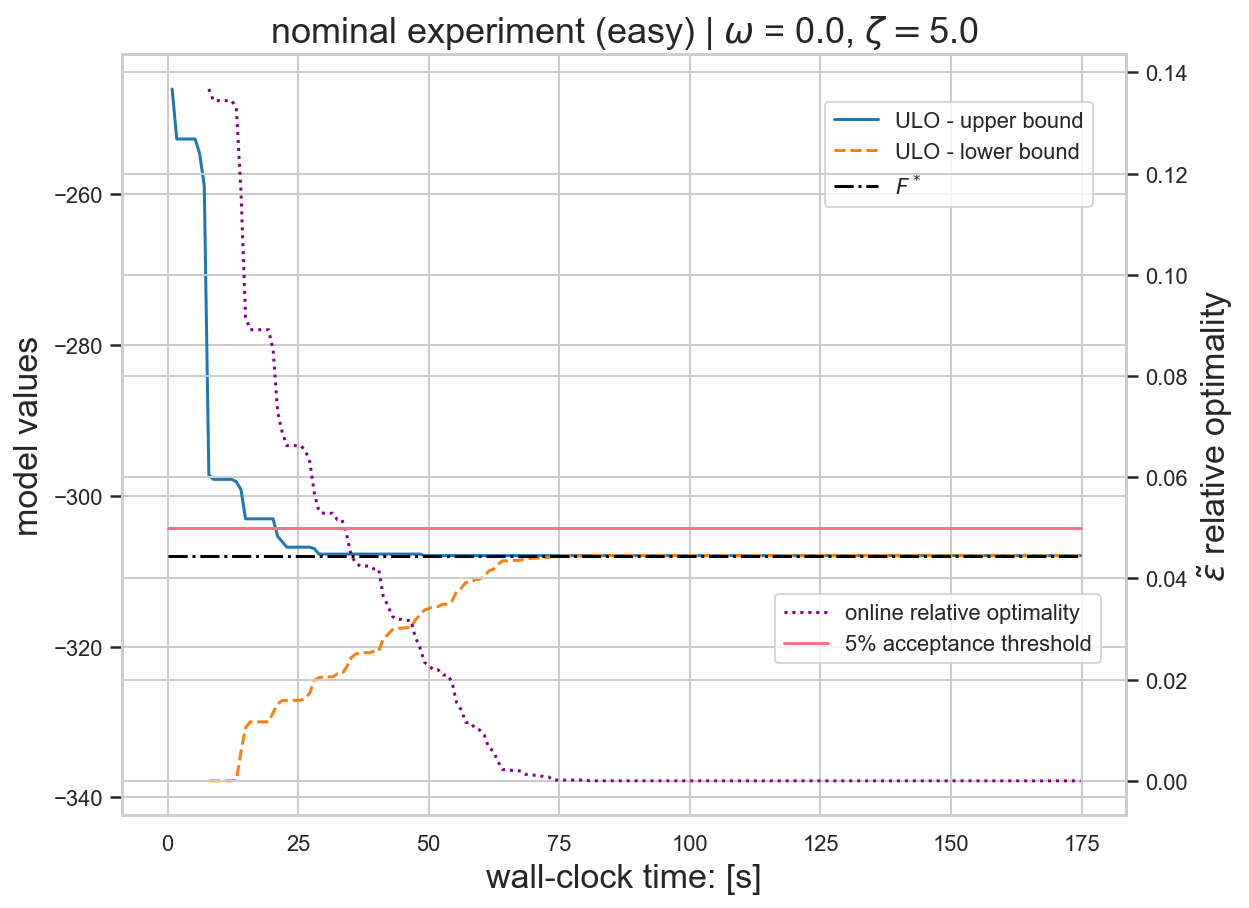

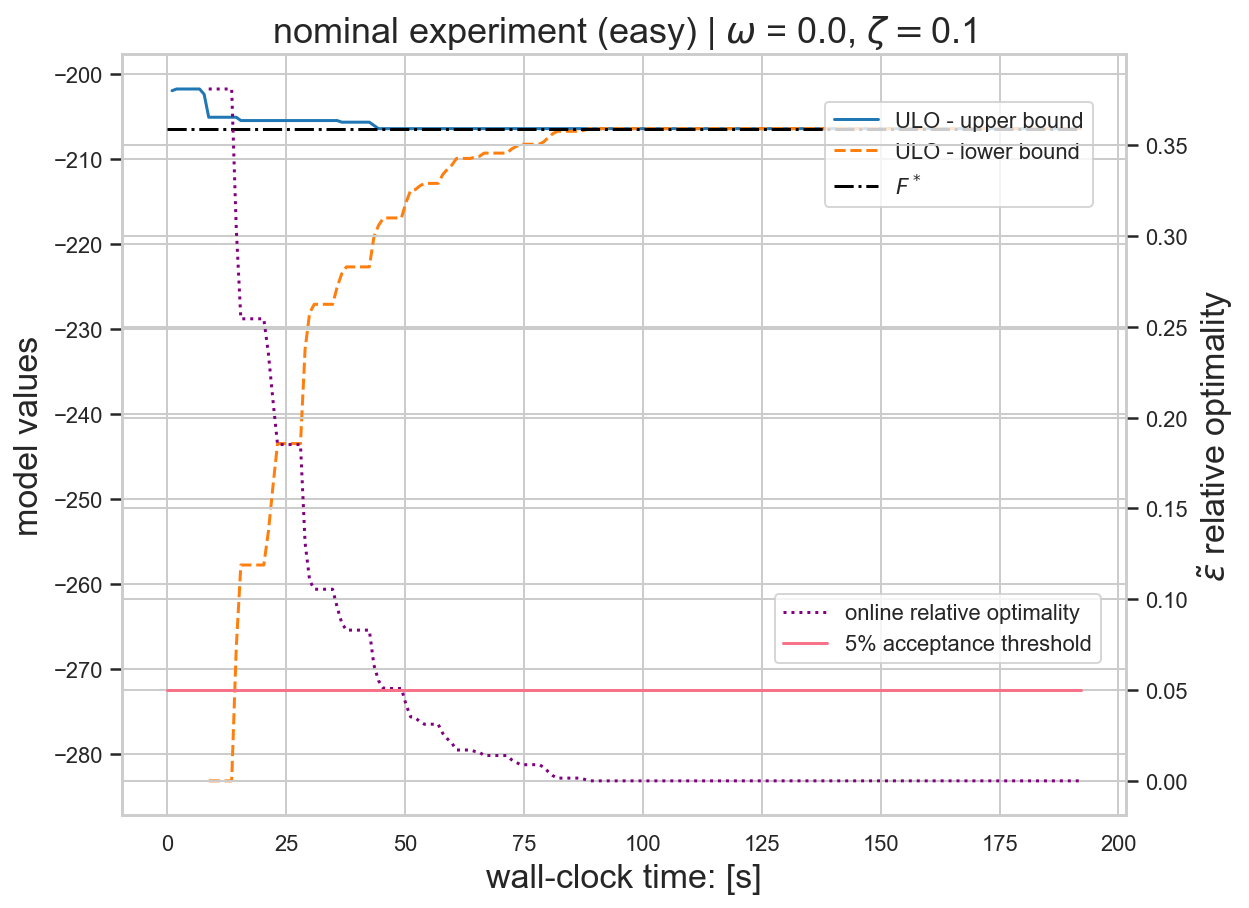

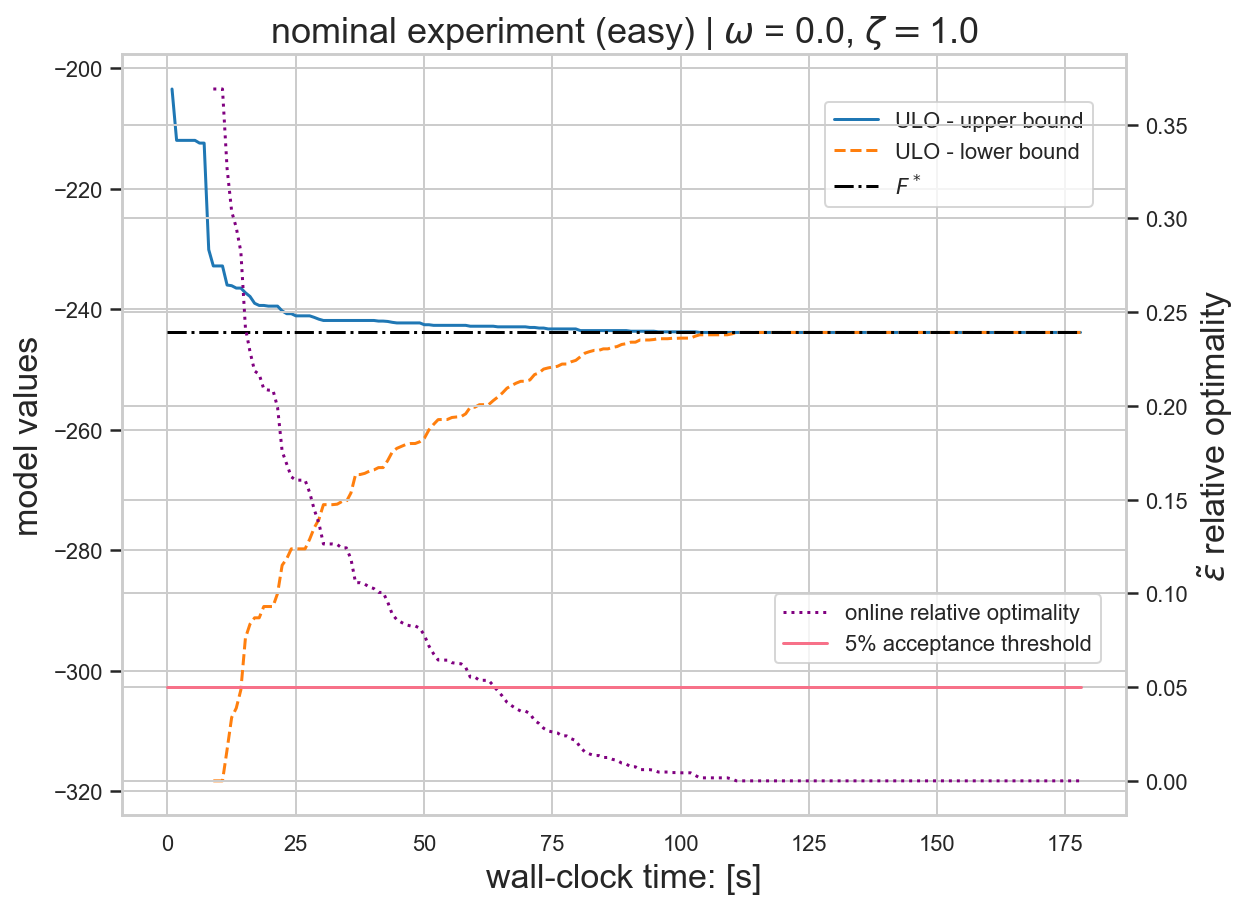

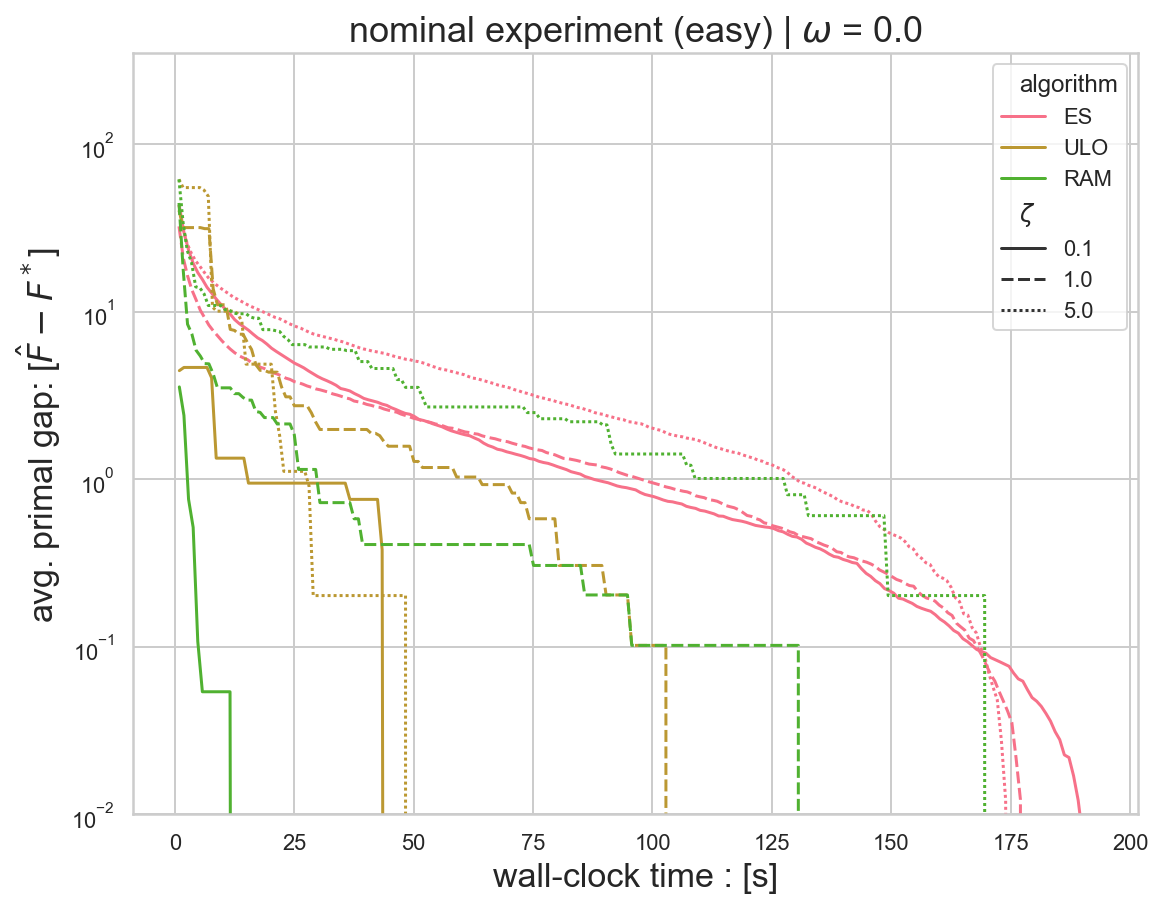

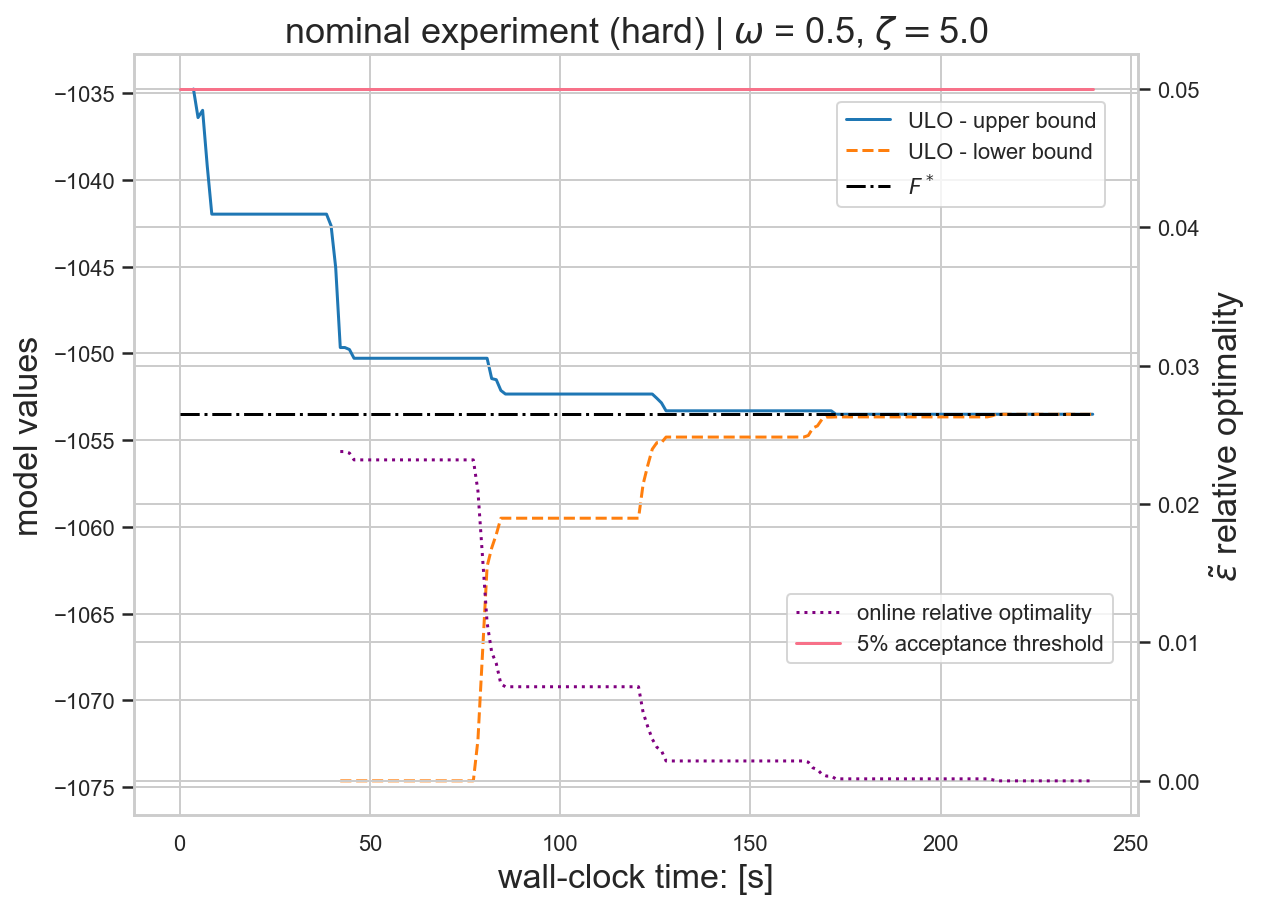

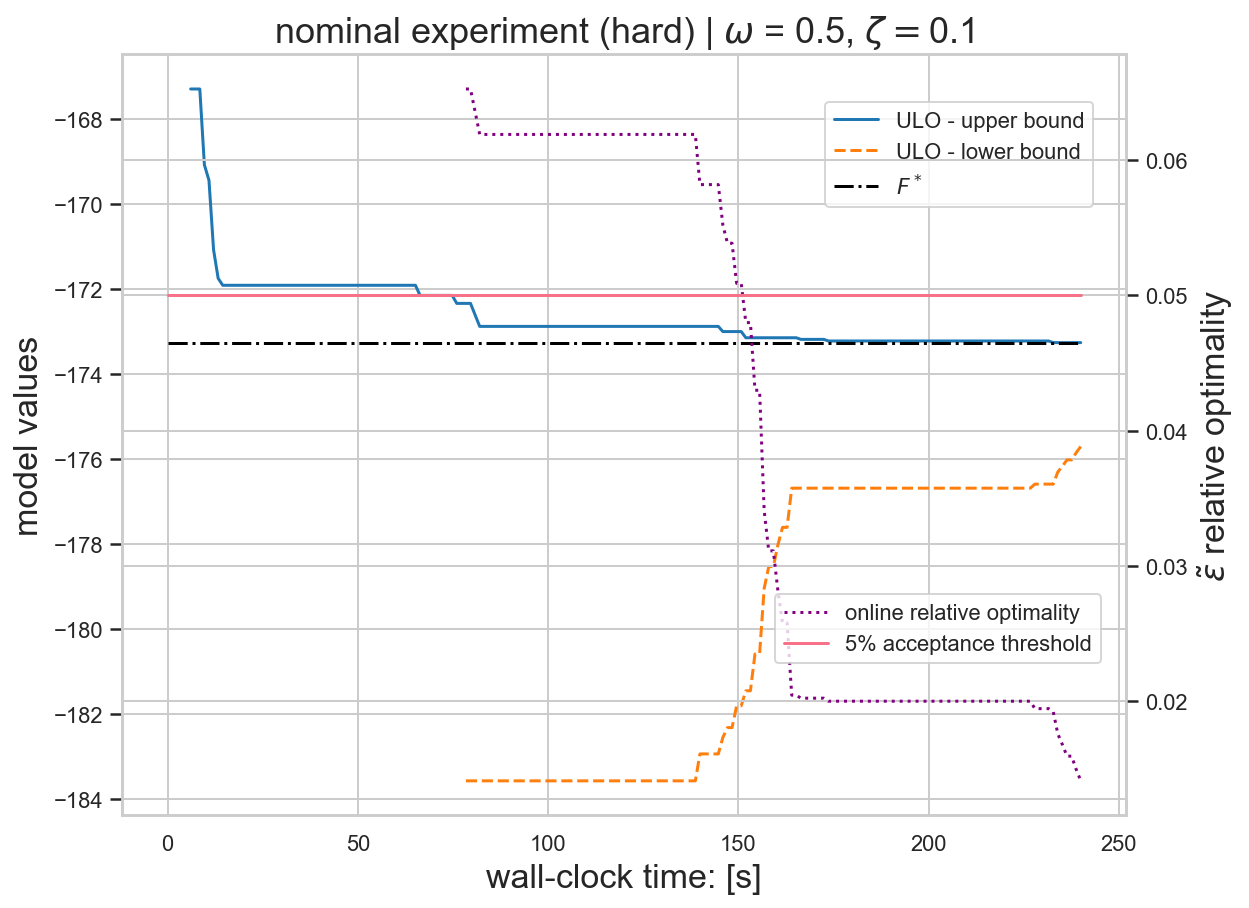

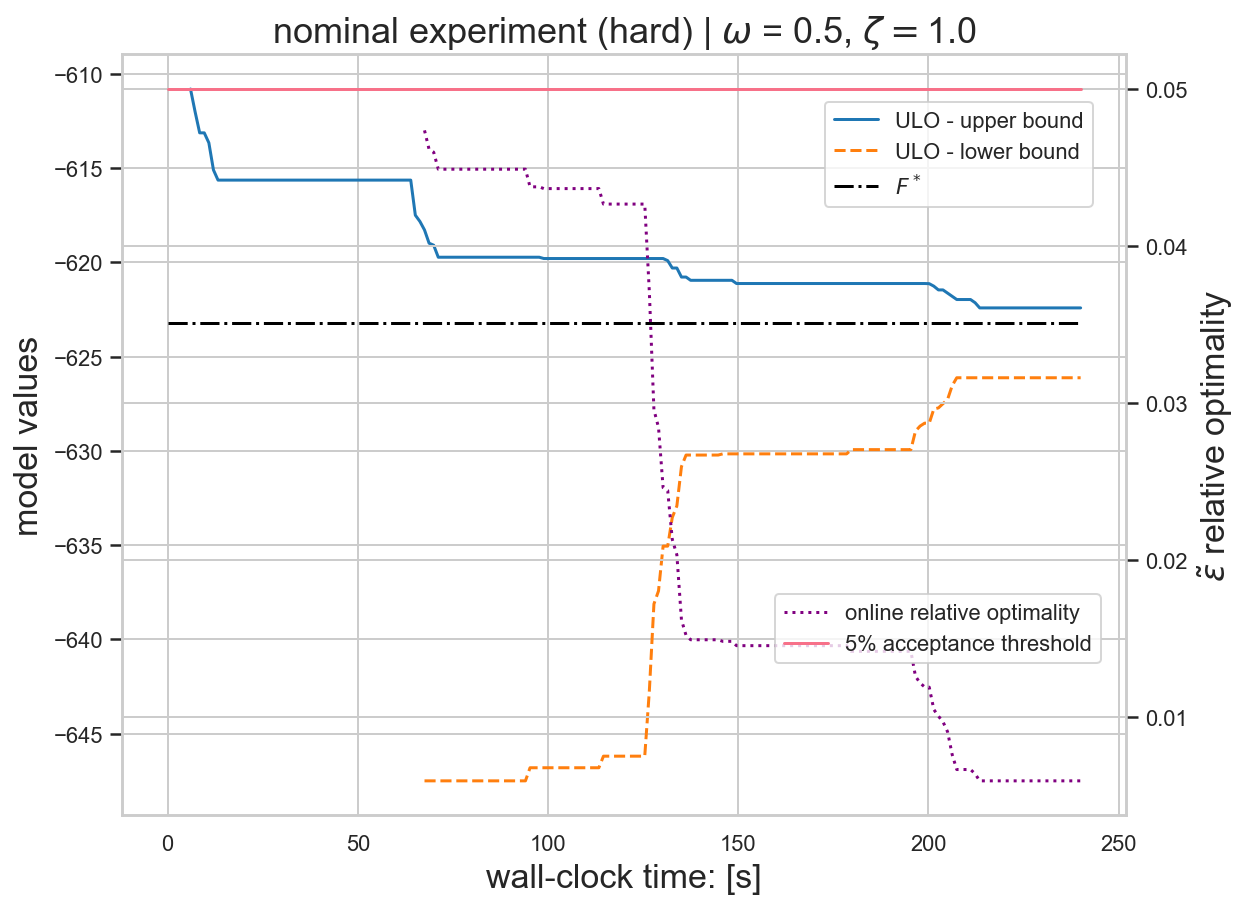

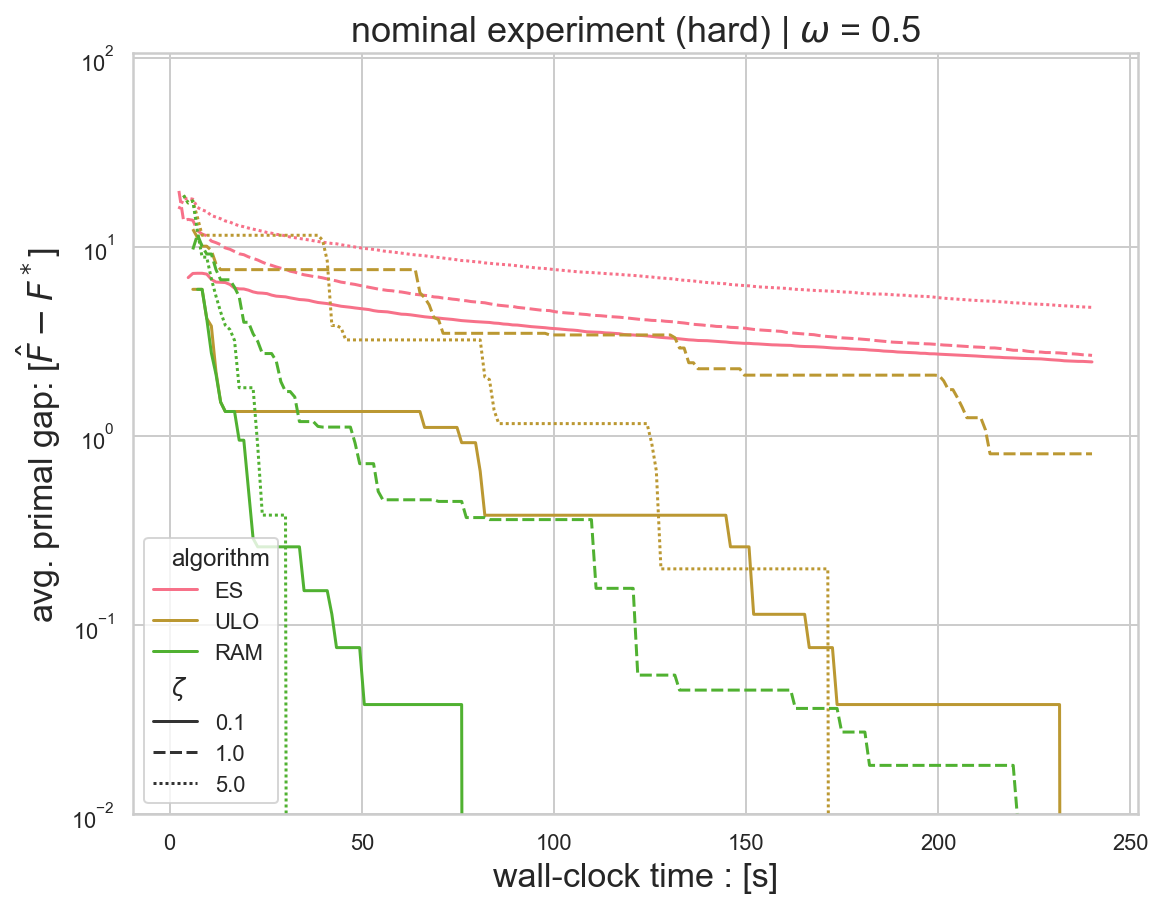

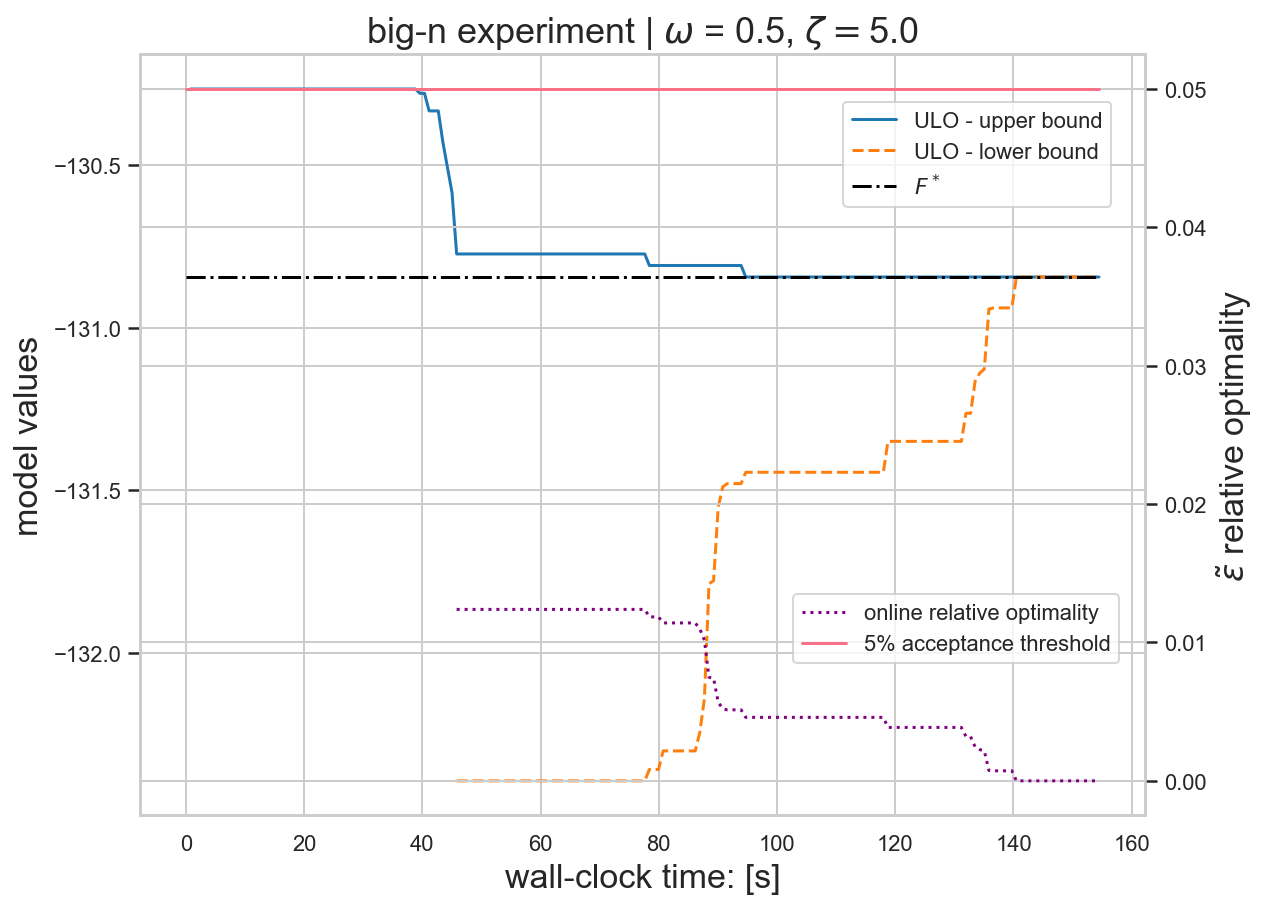

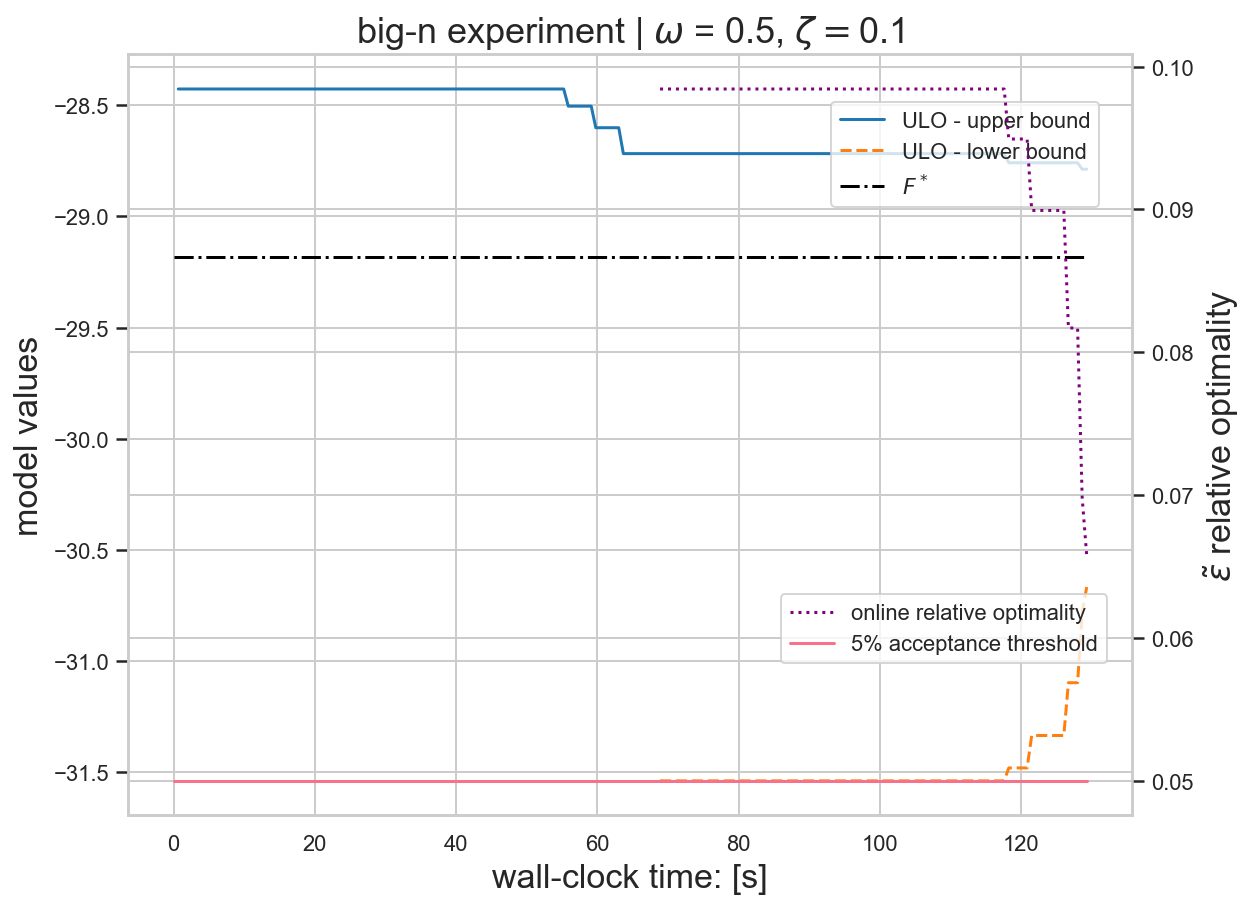

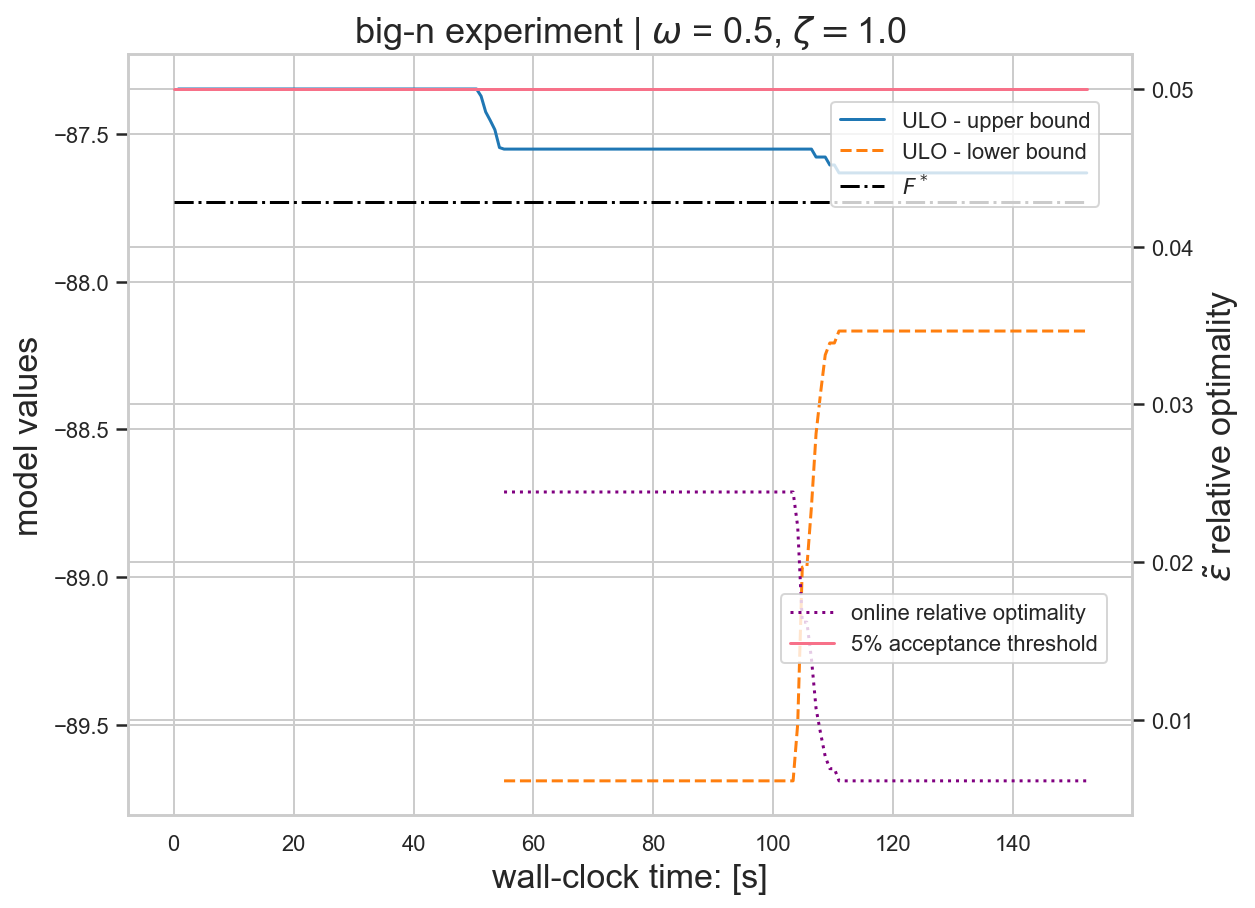

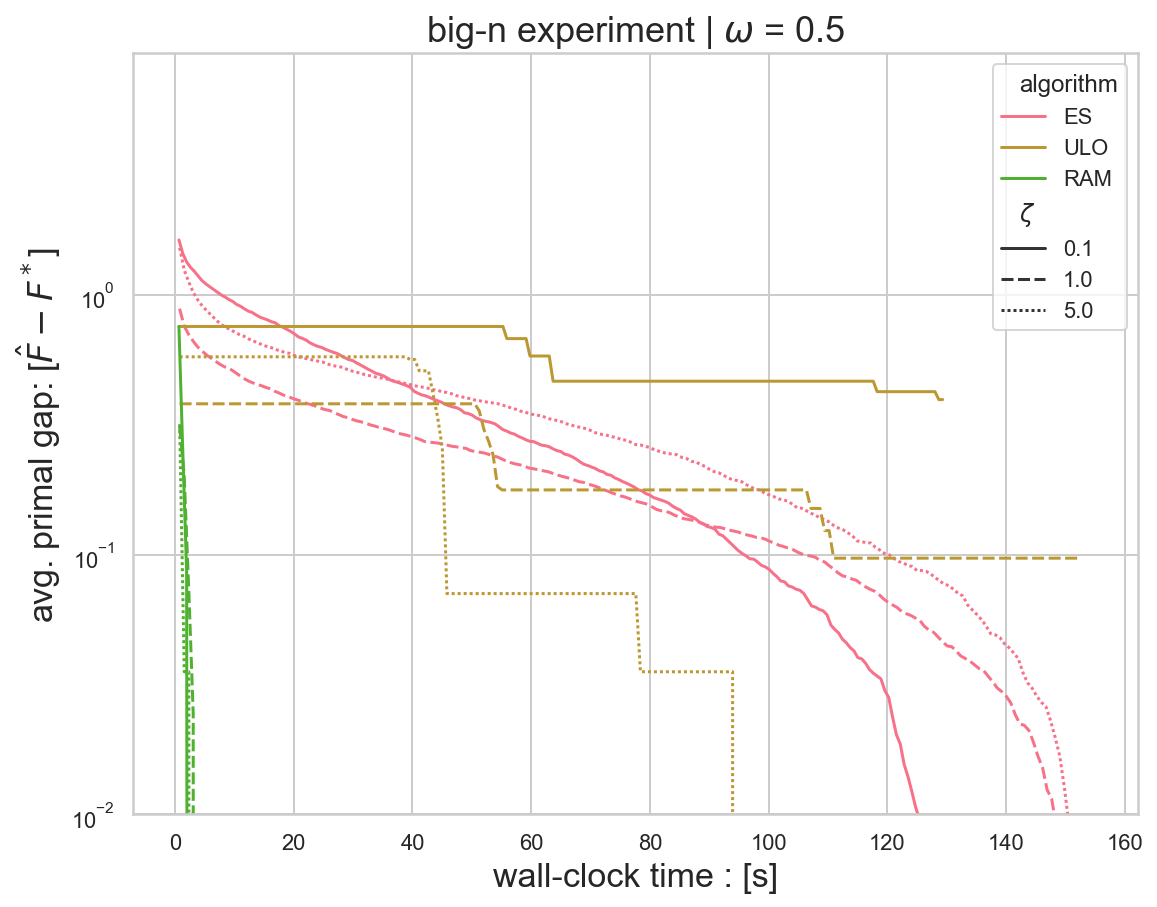

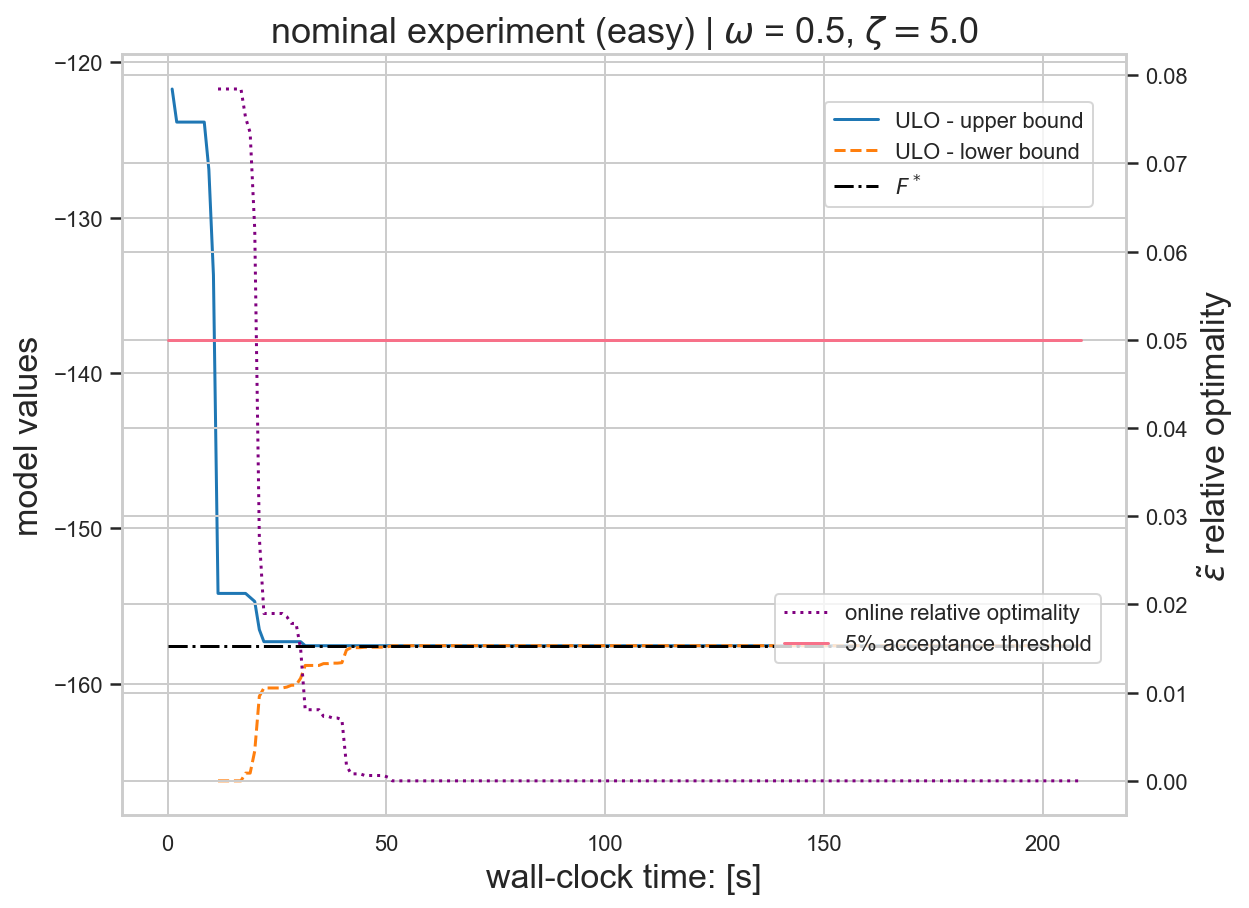

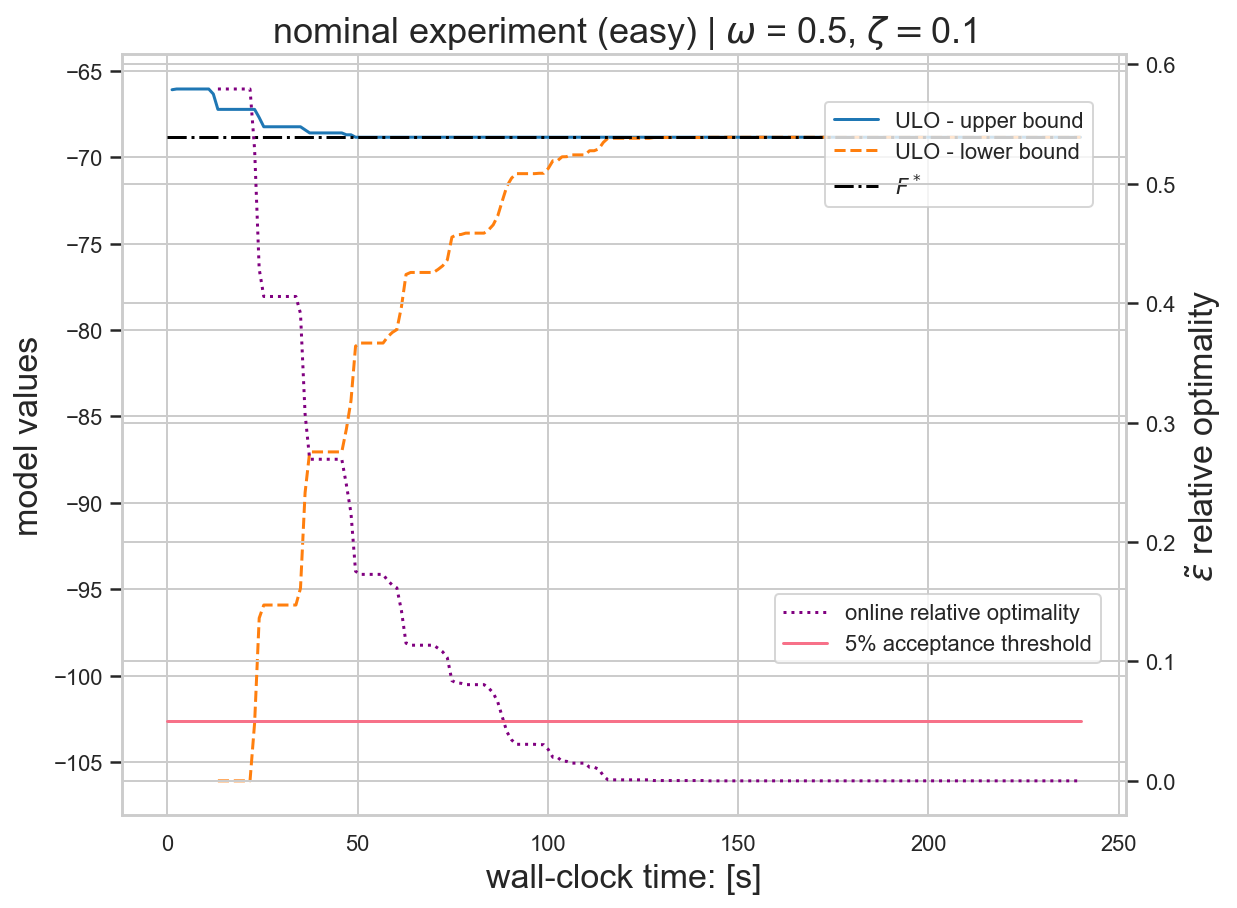

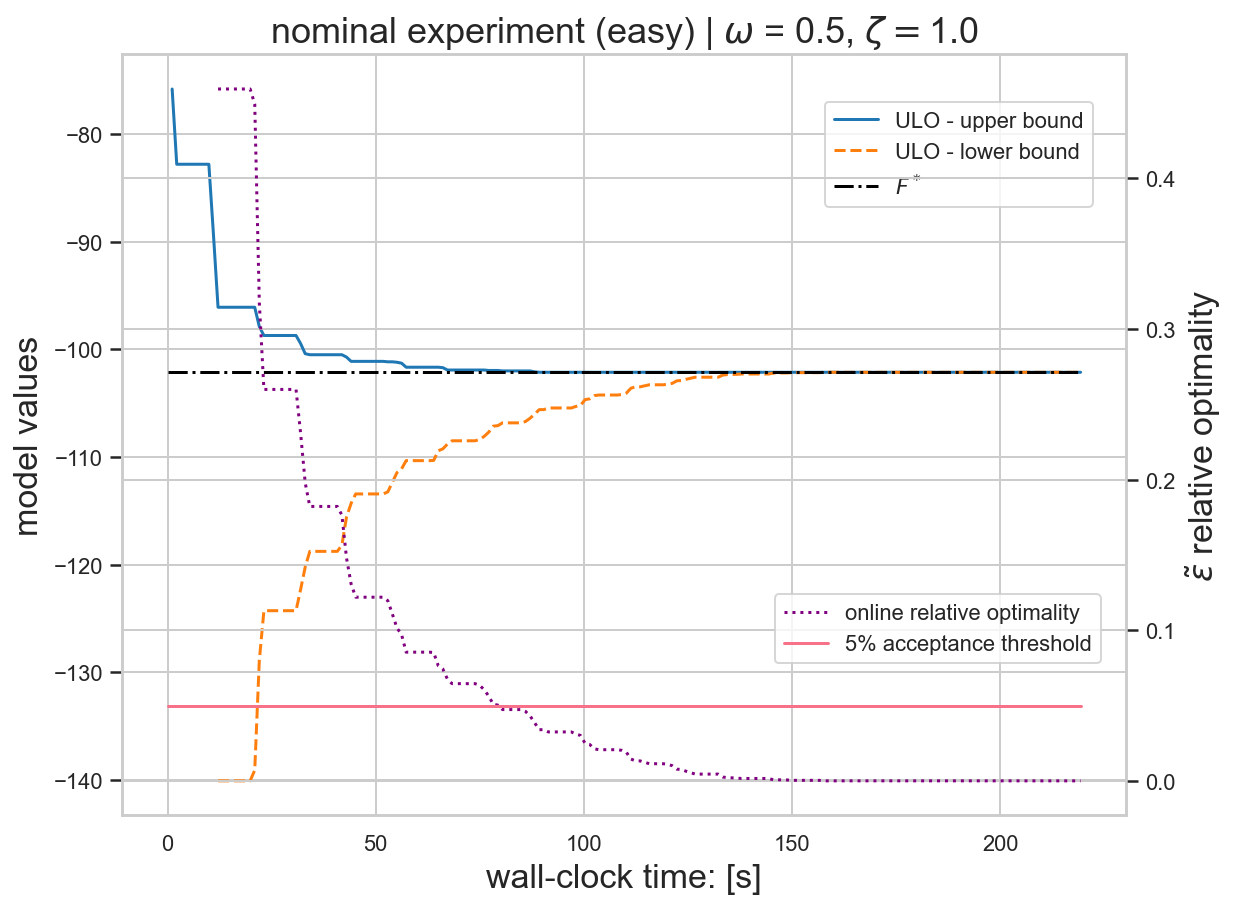

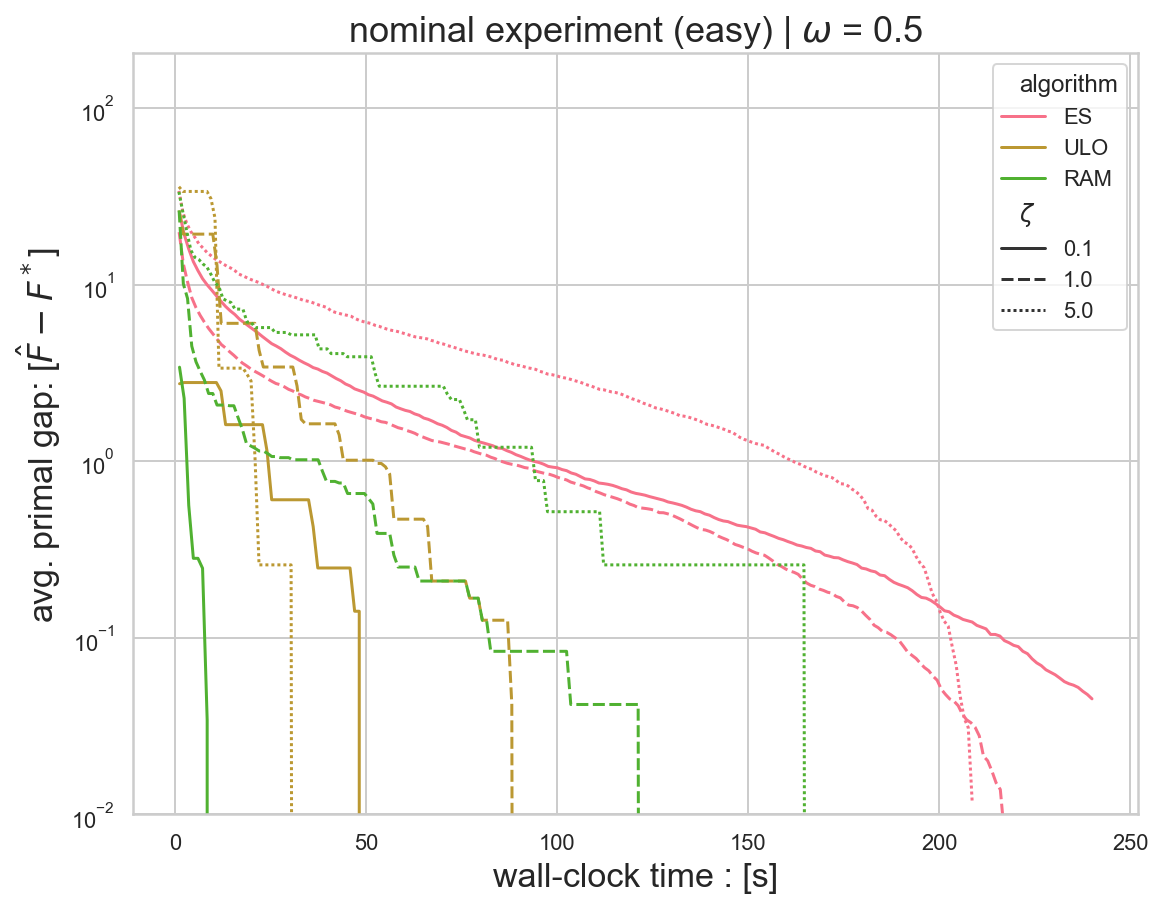

In [5]:
truth_df = full_raw_df[(full_raw_df['algo']=='ES')]
truth_df = truth_df[truth_df['bounds']<np.inf]

cuts = truth_df['cut'].unique()
omegas = truth_df['omega'].unique()
dims = truth_df['d'].unique()
rs = truth_df['r'].unique()
mults = truth_df['mult'].unique()
ns = truth_df['n'].unique()
ms = truth_df['m'].unique()

linestyles = ['-','-.',':']

NR = int(1e3)

counter_fig = 0

DICO = {}


for omega_elem,dim_elem,r_elem,mult_elem,n_elem,m_elem in itertools.product(*[omegas,dims,rs,mults,ns,ms]):
    pre_truth_df = truth_df[(truth_df['omega']==omega_elem)&(truth_df['d']==dim_elem)&\
                              (truth_df['r']==r_elem)&(truth_df['mult']==mult_elem)&(truth_df['n']==n_elem)&(truth_df['m']==m_elem)]
    rest_df = full_raw_df[(full_raw_df['omega']==omega_elem)&(full_raw_df['d']==dim_elem)&\
                              (full_raw_df['r']==r_elem)&(full_raw_df['mult']==mult_elem)&(full_raw_df['n']==n_elem)&(full_raw_df['m']==m_elem)]

    local_times = []
    local_values = []
    local_iota = []
    local_algorithm = []

    
    for idc,cut_elem in enumerate(cuts):
    
        truth_subdf = pre_truth_df[pre_truth_df['cut']==cut_elem]
        rest_subdf = rest_df[rest_df['cut']==cut_elem]
        
        smoothed_perf_ulo = []
        smoothed_perf_ram = []
        
        if len(truth_subdf.values)>0:
            values_es = truth_subdf['bounds'].values
            times_es = truth_subdf['times'].values
            smoothed_perf_ulo = []
            smoothed_perf_ram = []
            smoothed_perf_es = []
            smoothed_perf_ulo_relopt = []
            smoothed_perf_ulo_lb = []
            min_val = min(values_es)
            DICO[(cut_elem,omega_elem,dim_elem,r_elem,mult_elem,n_elem,m_elem)] = min_val
            times_of_interest = np.linspace(0,min(240,max(times_es)),200)
            raw_run_log_es = np.array([times_es,values_es]).T
            list_run_logs = resample(raw_run_log_es,NR)
            for run_log_es in list_run_logs:
                smoothed_perf_es.append(smooth_filter(run_log_es,times_of_interest))
            smoothed_perf_mean_es_ub = np.nanmean(smoothed_perf_es,0)
            
            for rep in rest_df['repID'].unique():
                times_ulo,times_ram = rest_subdf[(rest_subdf['algo']=='ULO')&(rest_subdf['bound_type']=='UB')&(rest_subdf['repID']==rep)]['times'].values,rest_subdf[(rest_subdf['algo']=='RAM')&(rest_subdf['bound_type']=='UB')&(rest_subdf['repID']==rep)]['times'].values
                values_ulo,values_ram = rest_subdf[(rest_subdf['algo']=='ULO')&(rest_subdf['bound_type']=='UB')&(rest_subdf['repID']==rep)]['bounds'].values,rest_subdf[(rest_subdf['algo']=='RAM')&(rest_subdf['bound_type']=='UB')&(rest_subdf['repID']==rep)]['bounds'].values
                values_ulo_lb = rest_subdf[(rest_subdf['algo']=='ULO')&(rest_subdf['bound_type']=='LB')&(rest_subdf['repID']==rep)]['bounds'].values
                smoothed_perf_ulo.append(smooth_filter(np.array([times_ulo,values_ulo]).T,times_of_interest))
                smoothed_perf_ram.append(smooth_filter(np.array([times_ram,values_ram]).T,times_of_interest))
                smoothed_perf_ulo_lb.append(smooth_filter(np.array([times_ulo,values_ulo_lb]).T,times_of_interest))
                smoothed_perf_ulo_relopt.append(smooth_filter(np.array([times_ulo,(values_ulo-values_ulo_lb)/np.maximum(1,np.abs(values_ulo))]).T,times_of_interest))
            smoothed_perf_mean_ram_ub = np.nanmean(smoothed_perf_ram,0)
            smoothed_perf_mean_ulo_ub = np.nanmean(smoothed_perf_ulo,0)
            smoothed_perf_mean_ulo_lb = np.nanmean(smoothed_perf_ulo_lb,0)
            smoothed_perf_mean_ulo_relopt = np.nanmean(smoothed_perf_ulo_relopt,0)
            
            local_times +=  3*list(times_of_interest)
            local_values += list(smoothed_perf_mean_es_ub-min_val)+ list(smoothed_perf_mean_ulo_ub-min_val)+ list(smoothed_perf_mean_ram_ub-min_val)
            local_iota += 3*list(np.ones(len(times_of_interest))*cut_elem)
            local_algorithm += len(times_of_interest)*['ES']+len(times_of_interest)*['ULO']+len(times_of_interest)*['RAM']
              
            TOL_REL_DEF = 5e-2

            threshold_relative = min_val + TOL_REL_DEF*max(1,abs(min_val))
            fig,ax1 = plt.subplots(figsize=(9,7))
            ax2 = ax1.twinx()
            if n_elem<m_elem:
                if dim_elem>1e2:
                    experiment = 'first_'+str(omega_elem)
                    plt.title('nominal experiment (hard) | $\\omega$ = '+str(omega_elem)+', $\\zeta = $'+str(cut_elem),fontsize=18)
                else:
                    experiment = 'second_'+str(omega_elem)
                    plt.title('nominal experiment (easy) | $\\omega$ = '+str(omega_elem)+', $\\zeta = $'+str(cut_elem),fontsize=18)
            else:
                experiment = 'third_'+str(omega_elem)
                plt.title('big-n experiment | $\\omega$ = '+str(omega_elem)+', $\\zeta = $'+str(cut_elem),fontsize=18)
            ax1.plot(times_of_interest,smoothed_perf_mean_ulo_ub,label='ULO - upper bound',color='tab:blue',linestyle='-')
            ax1.plot(times_of_interest,smoothed_perf_mean_ulo_lb,label='ULO - lower bound',color='tab:orange',linestyle='--')
            ax2.plot(times_of_interest,smoothed_perf_mean_ulo_relopt,\
                    color='purple',linestyle=':',label='online relative optimality ')
            ax1.plot(times_of_interest,min_val*np.ones(len(times_of_interest)),linestyle='-.',label='$F^*$',color='black')
            ax1.set_xlabel('wall-clock time: [s]',fontsize=17)
            ax1.set_ylabel('model values',fontsize=17)
            ax2.set_ylabel('$\\tilde{\\epsilon}$ relative optimality',fontsize=17)
            ax2.plot(times_of_interest,np.ones(len(times_of_interest))*TOL_REL_DEF,label='5% acceptance threshold')
            ax1.legend(loc=(0.7,0.8))
            ax2.legend(loc=(0.65,0.2))
            #ax1.set_xlim([0,max(times_ulo)*1.1])
            plt.savefig(experiment+str(cut_elem)+'_'+str(counter_fig+1)+'_ulo_details.pdf',dpi=500);
    
    if len(local_times)>0:
        counter_fig+=1
        plt.figure(figsize=(9,7))
        local_df = pd.DataFrame(data={'times':local_times,'values':local_values,'$\\zeta$':local_iota,'algorithm':local_algorithm})
        sns.lineplot(data=local_df, x="times", y="values", hue="algorithm", style="$\\zeta$")
        plt.yscale('log')
        if n_elem<m_elem:
            if dim_elem>1e2:
                experiment = 'first_'
                plt.title('nominal experiment (hard) | $\\omega$ = '+str(omega_elem),fontsize=18)
            else:
                experiment = 'second_'
                plt.title('nominal experiment (easy) | $\\omega$ = '+str(omega_elem),fontsize=18)
        else:
            experiment = 'third_'
            plt.title('big-n experiment | $\\omega$ = '+str(omega_elem),fontsize=18)
        plt.xlabel('wall-clock time : [s]',fontsize=17)
        plt.ylabel('avg. primal gap: [$\\hat{F}-F^*$]',fontsize=17)
        plt.ylim([1e-2,None])
        plt.savefig(experiment+'fig_experiment_'+str(counter_fig)+'.pdf',dpi=500)